# Advanced Machine Learning : Project 1

The aim of the project is to use a synthesis of textual data from a large number of scientific articles on natural language processing. The TALN dataset is not really large, just 44MB, but it is large enough to be too complicated to be processed by hand. The way to generate the synthesis and the type of synthesis are totally open! We can focus on summaries or titles (less computational effort) or select a specific subset. If an approach does not work as expected, you can show and explain it. This project will contain a report to explain the logic of our approaches and results.

Dataset (44MB): https://www.ortolang.fr/market/corpora/corpus-taln

For our project we decided to focus on the articles' keywords and abstracts to make a synthesis of 20 years of Natural Language Processing (NLP). To illustrate this, we used five distinct visualizations : 

*   Word Frequency Cloud
*   Bar Chart Race
* TF-IDF
*   LDA
* T-SNE 

### Imports, Installations and Downloads

In [ ]:
# Installations
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
!pip install bar-chart-race
!pip install pyLDAvis

# NLTK imports
import nltk
from nltk.tag import UnigramTagger
from nltk.corpus import treebank, stopwords, wordnet
from nltk.tokenize import TreebankWordTokenizer, RegexpTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist

# Basic imports
from google.colab import drive
import unicodedata
import xml.etree.ElementTree as ET
import pandas as pd

# Spacy imports
import spacy
from spacy import displacy

# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Visualization imports
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import bar_chart_race as bcr
import pyLDAvis
import pyLDAvis.sklearn
from pyLDAvis import gensim

#Image
from IPython.display import Image

# Other imports
from collections import Counter
import en_core_web_sm
from gensim import corpora, models
from gensim.models import word2vec
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

# Download packets
nltk.download('treebank')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

## PREPROCESSING

Data preprocessing is an important step in the data exploration process.

###**Importing data**


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tree = ET.parse('/content/drive/MyDrive/ProjetNLP/corpus_taln_v1.tei.xml')

In [ ]:
root = tree.getroot()

### **Raw data to Dataframe**

For this project, the data was in the form of an xml file. Before starting we had to explore and navigate through the file to identify the different fields and get a better understanding of the structure. 
Once we’ve completed this step, we decided to retrieve only a few fields : the date, title, abstract in french, abstract in english, keywords in french and keywords in english.

That's what we're doing in the following section. First we define the path of data we want to retrieve, then we collect it and store it into arrays 


In [ ]:
path_date = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}teiHeader/{http://www.tei-c.org/ns/1.0}fileDesc/{http://www.tei-c.org/ns/1.0}publicationStmt/{http://www.tei-c.org/ns/1.0}date"
path_title = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}teiHeader/{http://www.tei-c.org/ns/1.0}fileDesc/{http://www.tei-c.org/ns/1.0}titleStmt/{http://www.tei-c.org/ns/1.0}title"
path_abstractFR = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}text/{http://www.tei-c.org/ns/1.0}front/{http://www.tei-c.org/ns/1.0}div[@type='abstract'][1]/{http://www.tei-c.org/ns/1.0}p" 
path_abstractEN = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}text/{http://www.tei-c.org/ns/1.0}front/{http://www.tei-c.org/ns/1.0}div[@type='abstract'][2]/{http://www.tei-c.org/ns/1.0}p"
path_keywordsFR = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}text/{http://www.tei-c.org/ns/1.0}front/{http://www.tei-c.org/ns/1.0}div[@type='keywords'][3]/{http://www.tei-c.org/ns/1.0}p" 
path_keywordsEN = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}text/{http://www.tei-c.org/ns/1.0}front/{http://www.tei-c.org/ns/1.0}div[@type='keywords'][4]/{http://www.tei-c.org/ns/1.0}p"

Extracting data from XML

In [ ]:
articles_date = []
for node in root.findall(path_date):
  articles_date.append(node.text)

articles_title = []
for node in root.findall(path_title):
  articles_title.append(node.text)

articles_abstractFR = []
for node in root.findall(path_abstractFR):
  articles_abstractFR.append(node.text)

articles_abstractEN = []
for node in root.findall(path_abstractEN):
  articles_abstractEN.append(node.text)

articles_keywordsEN = []
for node in root.findall(path_keywordsEN):
  articles_keywordsEN.append(node.text)

articles_keywordsFR = []
for node in root.findall(path_keywordsFR):
  articles_keywordsFR.append(node.text)


Once we were able to get the data from the different fields, we stored the data into a dataframe so it would be easier to use.

In [ ]:
df = pd.DataFrame(list(zip(articles_date, articles_title, articles_abstractFR, articles_abstractEN, articles_keywordsEN, articles_keywordsFR )), 
               columns =['date', 'title', 'abstractFR', 'abstractEN', 'keywordsEN', 'keywordsFR']) 
df.head()

,date,title,abstractFR,abstractEN,keywordsEN,keywordsFR
0,1997,\nÉléments de conception d'un système d'interp...,\nNous considérons dans notre travail la tâche...,None,None,None
1,1997,\nInformatisation du dictionnaire explicatif e...,\nNous donnons ici un aperçu du logiciel DECID...,None,None,None
2,1997,\nConstruction d'une représentation sémantique...,\nDiverses méthodes ont été proposées pour con...,None,None,None
3,1998,\nSystèmes de types pour la (lambda-)DRT ascen...,\nLe terme de lambda-DRT désigne un ensemble d...,None,None,None
4,1998,\nUne grammaire TAG vue comme une grammaire Se...,"\nDans cet article, nous comparons deux modèle...",None,None,None


###**Data cleaning**

Data cleaning is a very crucial step in any machine learning model, but more so for NLP. Without the cleaning process, the dataset is often a cluster of words that the computer doesn’t understand. Here, we will go over steps done in a typical machine learning text pipeline to clean data.


#### Remove special characters

To start of, we replace words containing an apostrophe. Then, we remove special characters, one character sentence, new lines and None. Lastly, we lowercase the words. 

In [ ]:
columns = ['date', 'title', 'abstractFR', 'abstractEN', 'keywordsEN', 'keywordsFR']

replacement = (("[Dd]\'", "de "),("[Qq]u\'", "que "), 
               ("[Ll]\'", "le "), ("[Jj]\'", "je "),
               ("[Cc]\'", "ce "), ("[Ss]\'", "se "),
               ("[Nn]\'", "ne "), ("[Mm]\'", "me "),
               ("[Tt]\'", "te "),  ("\'ll", " will"),
               ("I\'m", "i am"),("\'d", " would"), 
               ("\'s", " is"),("n\'t", " not"), 
               ("\'ve", " have") , ("\'re", " are")
               )

for col in columns: 
  for r in replacement:
    # replace words containing an apostrophe 
    df[col] = df[col].str.replace(*r)
  # remove special characters, One character sentence, new lines and None
  df[col] = df[col].str.replace('[\-\[\]+;\'!\^:/,"#&@\(\)\$\?%\_\*«»]|[A-Z]\.|None|\n', '')
  # lowercase words
  df[col] = df[col].str.lower()

df['keywordsEN'] = df['keywordsEN'].str.replace('\.', '')
df['keywordsFR'] = df['keywordsFR'].str.replace('\.', '')
df.fillna('',inplace=True)

#### Stopwords

We remove the commonly used words. Later, we might need to add some stopwords.

In [ ]:
stop_en = stopwords.words('english')
stop_fr = stopwords.words('french')

In [ ]:
df['processed_abstractFR'] = df['abstractFR'].apply(lambda x : ' '.join([word.lower() for word in x.split() if word.lower() not in stop_fr])) 
df['processed_abstractEN'] = df['abstractEN'].apply(lambda x : ' '.join([word.lower() for word in x.split() if word.lower() not in stop_en])) 
df['processed_keywordsFR'] = df['keywordsFR'].apply(lambda x : ' '.join([word.lower() for word in x.split() if word.lower() not in stop_fr])) 
df['processed_keywordsEN'] = df['keywordsEN'].apply(lambda x : ' '.join([word.lower() for word in x.split() if word.lower() not in stop_en])) 
df['processed_title'] = df['title'].apply(lambda x : ' '.join([word.lower() for word in x.split() if word.lower() not in stop_fr])) 

In [ ]:
df.head()

,date,title,abstractFR,abstractEN,keywordsEN,keywordsFR,processed_abstractFR,processed_abstractEN,processed_keywordsFR,processed_keywordsEN,processed_title
0,1997,éléments de conception de un système de interp...,nous considérons dans notre travail la tâche d...,,,,considérons travail tâche traitement automatiq...,,,,éléments conception système interprétation aut...
1,1997,informatisation du dictionnaire explicatif et ...,nous donnons ici un aperçu du logiciel decid d...,,,,donnons ici aperçu logiciel decid développé ge...,,,,informatisation dictionnaire explicatif combin...
2,1997,construction de une représentation sémantique ...,diverses méthodes ont été proposées pour const...,,,,diverses méthodes proposées construire graphe ...,,,,construction représentation sémantique graphes...
3,1998,systèmes de types pour la lambdadrt ascendante,le terme de lambdadrt désigne un ensemble de m...,,,,terme lambdadrt désigne ensemble méthodes perm...,,,,systèmes types lambdadrt ascendante
4,1998,une grammaire tag vue comme une grammaire sens...,dans cet article nous comparons deux modèles l...,,,,cet article comparons deux modèles linguistiqu...,,,,grammaire tag vue comme grammaire senstexte pr...


#### Tokenization

Now that we have removed the stopwords and cleaned the sentences, we need to tokenize the documents. Tokenization is a way of separating a piece of text into smaller units called tokens. It is a common task in Natural Language Processing.

In [ ]:
df['processed_sent_abstractFR'] = df.apply(lambda row : nltk.sent_tokenize(row['processed_abstractFR']), axis=1 )
df['processed_sent_abstractEN'] = df.apply(lambda row : nltk.sent_tokenize(row['processed_abstractEN']), axis=1 )
df['processed_word_keywordsFR'] = df.apply(lambda row : nltk.word_tokenize(row['processed_keywordsFR']), axis=1 )
df['processed_word_keywordsEN'] = df.apply(lambda row : nltk.word_tokenize(row['processed_keywordsEN']), axis=1 )
df['processed_word_abstractFR'] = df.apply(lambda row : nltk.word_tokenize(row['processed_abstractFR']), axis=1 )
df['processed_word_abstractEN'] = df.apply(lambda row : nltk.word_tokenize(row['processed_abstractEN']), axis=1 )

In [ ]:
df.head()

,date,title,abstractFR,abstractEN,keywordsEN,keywordsFR,processed_abstractFR,processed_abstractEN,processed_keywordsFR,processed_keywordsEN,processed_title,processed_sent_abstractFR,processed_sent_abstractEN,processed_word_keywordsFR,processed_word_keywordsEN,processed_word_abstractFR,processed_word_abstractEN
0,1997,éléments de conception de un système de interp...,nous considérons dans notre travail la tâche d...,,,,considérons travail tâche traitement automatiq...,,,,éléments conception système interprétation aut...,[considérons travail tâche traitement automati...,[],[],[],"[considérons, travail, tâche, traitement, auto...",[]
1,1997,informatisation du dictionnaire explicatif et ...,nous donnons ici un aperçu du logiciel decid d...,,,,donnons ici aperçu logiciel decid développé ge...,,,,informatisation dictionnaire explicatif combin...,[donnons ici aperçu logiciel decid développé g...,[],[],[],"[donnons, ici, aperçu, logiciel, decid, dévelo...",[]
2,1997,construction de une représentation sémantique ...,diverses méthodes ont été proposées pour const...,,,,diverses méthodes proposées construire graphe ...,,,,construction représentation sémantique graphes...,[diverses méthodes proposées construire graphe...,[],[],[],"[diverses, méthodes, proposées, construire, gr...",[]
3,1998,systèmes de types pour la lambdadrt ascendante,le terme de lambdadrt désigne un ensemble de m...,,,,terme lambdadrt désigne ensemble méthodes perm...,,,,systèmes types lambdadrt ascendante,[terme lambdadrt désigne ensemble méthodes per...,[],[],[],"[terme, lambdadrt, désigne, ensemble, méthodes...",[]
4,1998,une grammaire tag vue comme une grammaire sens...,dans cet article nous comparons deux modèles l...,,,,cet article comparons deux modèles linguistiqu...,,,,grammaire tag vue comme grammaire senstexte pr...,[cet article comparons deux modèles linguistiq...,[],[],[],"[cet, article, comparons, deux, modèles, lingu...",[]


#### Lemmatization

This is another technique used to reduce words to a normalized form. In lemmatization, the transformation uses a dictionary to map different variants of a word back to its root format. So, with this approach, we are able to reduce non trivial inflections such as “is”, “was”, “were” back to the root “be”.

English Lemmatization



In [ ]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def multiple_lemmatize_sentence(array):
  if len(array) > 0:
    local = []
    for sentence in array:
      #tokenize the sentence and find the POS tag for each token
      nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
      #tuple of (token, wordnet_tag)
      wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
      lemmatized_sentence = []
      for word, tag in wordnet_tagged:
          if tag is None:
              #if there is no available tag, append the token as is
              lemmatized_sentence.append(word)
          else:        
              #else use the tag to lemmatize the token
              lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
      local.append(" ".join(lemmatized_sentence))
    return local
  else:
    return []


print( multiple_lemmatize_sentence(["new variant structured contextual grammar generates dependency trees introduced", "He is loving it"]))


['new variant structure contextual grammar generates dependency tree introduce', 'He be love it']


We can see above that some words are still not  properly lemmatized such as "generates" and some others are  properly lemmatized such as "is" which becomes "be". 

However, we decided to continue with this lemmatization because it worked in most of the cases.

In [ ]:
df['processed_sent_abstractEN'] = df.apply(lambda row : multiple_lemmatize_sentence(row['processed_sent_abstractEN']), axis=1 )
df['processed_word_keywordsEN'] = df.apply(lambda row : multiple_lemmatize_sentence(row['processed_word_keywordsEN']), axis=1 )

French Lemmatization

We proceeded by doing the french lemmatization but we concluded that the results were not as good as the english lemmatization. 

In [ ]:
lemmatizer = FrenchLefffLemmatizer()
print(lemmatizer.lemmatize("declarations"))

declarations


In [ ]:
lemmatizer=FrenchLefffLemmatizer()
tokenizer = TreebankWordTokenizer()

def lemmatize_text(text):
  local = []
  for t in text:
    t = tokenizer.tokenize(t)
    t = ' '.join([lemmatizer.lemmatize(word) for word in t])
    local.append(t)
  return local

print(lemmatize_text(["déclarations sommes", "lundi mardi technologies"]))

['déclaration somme', 'lundi mardi technologie']


In [ ]:
df['processed_sent_abstractFR'] = df.apply(lambda row : lemmatize_text(row['processed_sent_abstractFR']), axis=1 )
df['processed_word_keywordsFR'] = df.apply(lambda row : lemmatize_text(row['processed_word_keywordsFR']), axis=1 )

In [ ]:
df.head()

,date,title,abstractFR,abstractEN,keywordsEN,keywordsFR,processed_abstractFR,processed_abstractEN,processed_keywordsFR,processed_keywordsEN,processed_title,processed_sent_abstractFR,processed_sent_abstractEN,processed_word_keywordsFR,processed_word_keywordsEN,processed_word_abstractFR,processed_word_abstractEN
0,1997,éléments de conception de un système de interp...,nous considérons dans notre travail la tâche d...,,,,considérons travail tâche traitement automatiq...,,,,éléments conception système interprétation aut...,[considérons travail tâche traitement automati...,[],[],[],"[considérons, travail, tâche, traitement, auto...",[]
1,1997,informatisation du dictionnaire explicatif et ...,nous donnons ici un aperçu du logiciel decid d...,,,,donnons ici aperçu logiciel decid développé ge...,,,,informatisation dictionnaire explicatif combin...,[donnons ici aperçu logiciel decid développé g...,[],[],[],"[donnons, ici, aperçu, logiciel, decid, dévelo...",[]
2,1997,construction de une représentation sémantique ...,diverses méthodes ont été proposées pour const...,,,,diverses méthodes proposées construire graphe ...,,,,construction représentation sémantique graphes...,[diverses méthode proposées construire graphe ...,[],[],[],"[diverses, méthodes, proposées, construire, gr...",[]
3,1998,systèmes de types pour la lambdadrt ascendante,le terme de lambdadrt désigne un ensemble de m...,,,,terme lambdadrt désigne ensemble méthodes perm...,,,,systèmes types lambdadrt ascendante,[terme lambdadrt désigne ensemble méthode perm...,[],[],[],"[terme, lambdadrt, désigne, ensemble, méthodes...",[]
4,1998,une grammaire tag vue comme une grammaire sens...,dans cet article nous comparons deux modèles l...,,,,cet article comparons deux modèles linguistiqu...,,,,grammaire tag vue comme grammaire senstexte pr...,[cet article comparons deux modèle linguistiqu...,[],[],[],"[cet, article, comparons, deux, modèles, lingu...",[]


####Remove french accents

Thereafter, we removed the french accents, we did that after the lemmatization because we noticed that we would've gotten even worst results by doing it before french lemmatiation.

In [ ]:
def remove_accented_chars(text):
  local=[]
  for t in text:
    t = unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    local.append(t)
  return local

df['processed_sent_abstractFR'] = df.apply(lambda row : remove_accented_chars(row['processed_sent_abstractFR']), axis=1 )

#### Remove end of line dots

Finally, we remove the dots that were present at the end of the lines because the sentences are now splitted into words. 

In [ ]:
def rmvdot(row):
  try:
    local = []
    for sentence in row:
      local.append(sentence.replace(' .', ''))
    return local
  except:
    return None

df['processed_sent_abstractFR'] = df.apply(lambda row : rmvdot(row['processed_sent_abstractFR']), axis=1 )
df['processed_sent_abstractEN'] = df.apply(lambda row : rmvdot(row['processed_sent_abstractEN']), axis=1 )

## EXPLORATION

Our abstracts and keywords are finally pre-processed (removing special characters, removing commonly used words, splitting sentences into words, ...). In order to have a better understanding of our data, we found it interesting to apply named entity recognition on the english abstracts as well as part of speech tagging, even though we will not be using it in the different methods below. 

**Word Explorations** 

> Named Entity Recognition



NER is the task of identifying and categorizing key information (entities) in text



In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
# create a column containing list of Named Entity Recognition
def ner(row):
  if len(row) != 0:
    doc = nlp(' '.join(row))
    return [(X.text, X.label_) for X in doc.ents]
  else:
    return None

df['NER'] = df.apply(lambda row : ner(row['processed_sent_abstractEN']), axis=1 )

In [ ]:
print(df['NER'].iloc[123])

[('french', 'NORP'), ('two', 'CARDINAL')]


> Part of Speech Tagging

POS tagging is the process of marking up a word in a corpus to a corresponding part of a speech tag, based on its context and definition

In [ ]:
nlp = spacy.load("en_core_web_sm") 
  
# create a column containing list of the verbs, nouns, ... for each abstract
def pos(row):
  if len(row) != 0:
    doc = nlp(' '.join(row))
    Verb = "Verbs:", [token.text for token in doc if token.pos_ == "VERB"]
    Noun = "Nouns:", [token.text for token in doc if token.pos_ == "NOUN"]
    Det = "Det:", [token.text for token in doc if token.pos_ == "DET"]
    Adj = "Adj:", [token.text for token in doc if token.pos_ == "ADJ"]
    Propn = "Propn:", [token.text for token in doc if token.pos_ == "PROPN"] 
    return [Verb, Noun, Det, Adj, Propn]
  else:
    return None

df['POS'] = df.apply(lambda row : pos(row['processed_sent_abstractEN']), axis=1 )


For each abstracts we have grouped the different POS tagging togethers. 

In [ ]:
print(df['POS'].iloc[123])

[('Verbs:', ['contextscanning', 'carry', 'lefttoright', 'integrate', 'chartparsing', 'improve']), ('Nouns:', ['system', 'extraction', 'expression', 'text', 'identification', 'expression', 'base', 'strategy', 'technique', 'search', 'expressios', 'chartparsing', 'number', 'distantdependency', 'constraint', 'procedure', 'order', 'precision', 'system']), ('Det:', []), ('Adj:', ['present', 'temporal', 'french', 'temporal', 'complementary', 'regular', 'righttoleft', 'local', 'semantic']), ('Propn:', ['cs'])]


**Word Frequency**

Afterwards we calculate the word frequencies.

The goal is to get a "general feel" of what the articles talk about.

To better represent the word frequencies, we chose to use a tag cloud representation, because it allows us to quickly see the frequency of each words.

> **English Keywords**




In [ ]:
keywords = []
for x in df['processed_word_keywordsEN']: 
  if len(x) != 0:  
    keywords.append(x)

fdist = FreqDist([val for words in keywords for val in words])
fdist.most_common(10)


[('language', 180),
 ('corpus', 175),
 ('analysis', 157),
 ('grammar', 154),
 ('semantic', 152),
 ('lexical', 141),
 ('information', 134),
 ('machine', 129),
 ('translation', 126),
 ('extraction', 119)]

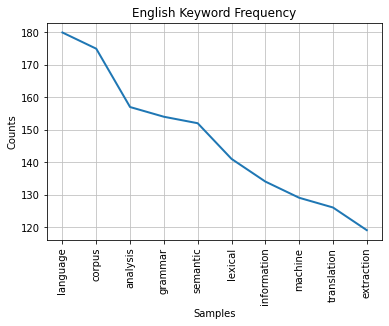

In [ ]:
fdist.plot(10,cumulative=False, title="English Keyword Frequency")

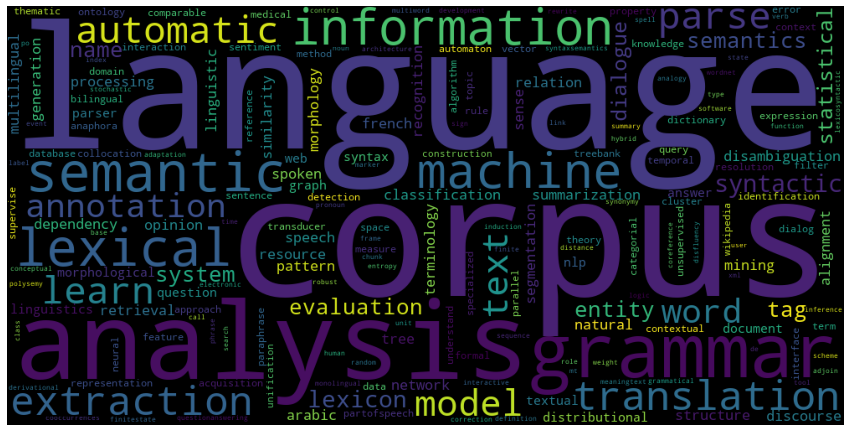

In [ ]:
my_list = [val for words in keywords for val in words]
word_could_dict=Counter(my_list)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Thus, we are able to see graphically and visually that the most common word in the english keywords are language and corpus. 

Furthermore the results are relevant because all the most frequent words are linked to the NLP field.



> **French Keywords**



In [ ]:
keywords = []
for x in df['processed_word_keywordsFR']: 
  if len(x) != 0:  
    keywords.append(x)

fdist = FreqDist([val for words in keywords for val in words])
fdist.most_common(10)

[('analyse', 322),
 ('automatique', 303),
 ('sémantique', 260),
 ('corpus', 244),
 ('grammaire', 162),
 ('traduction', 157),
 ('extraction', 151),
 ('information', 149),
 ('syntaxique', 144),
 ('apprentissage', 142)]

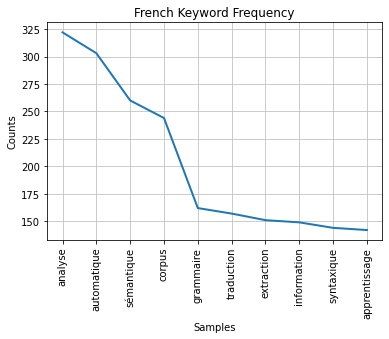

In [ ]:
fdist.plot(10,cumulative=False, title="French Keyword Frequency")

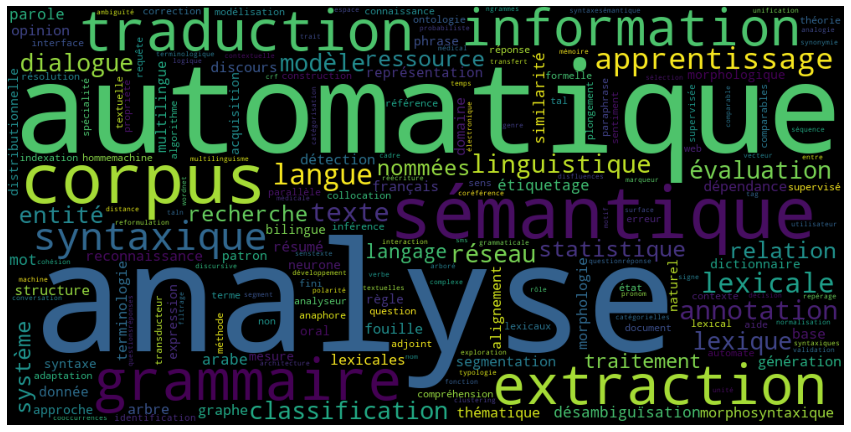

In [ ]:
my_list = [val for words in keywords for val in words]
word_could_dict=Counter(my_list)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

As a result, we are able to see graphically and visually that the most common word in the french keyword are analyse and automatique. 

Additionally, the results are relevant because all the most frequent words are linked to the NLP field.



> English Abstract Words



In [ ]:
AbstractWord = []
def listWordAbstract(row): 
  if len(row) != 0:
    AbstractWord.append(' '.join(row))

df['WordEN'] = df.apply(lambda row : listWordAbstract(row['processed_sent_abstractEN']), axis=1 )

fdist = FreqDist((' '.join(AbstractWord)).split(" "))
fdist.most_common(10)

[('use', 1026),
 ('system', 797),
 ('present', 749),
 ('corpus', 726),
 ('language', 672),
 ('paper', 650),
 ('method', 600),
 ('word', 526),
 ('result', 522),
 ('approach', 515)]

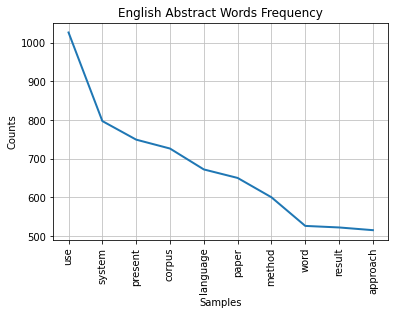

In [ ]:
fdist.plot(10,cumulative=False, title="English Abstract Words Frequency")

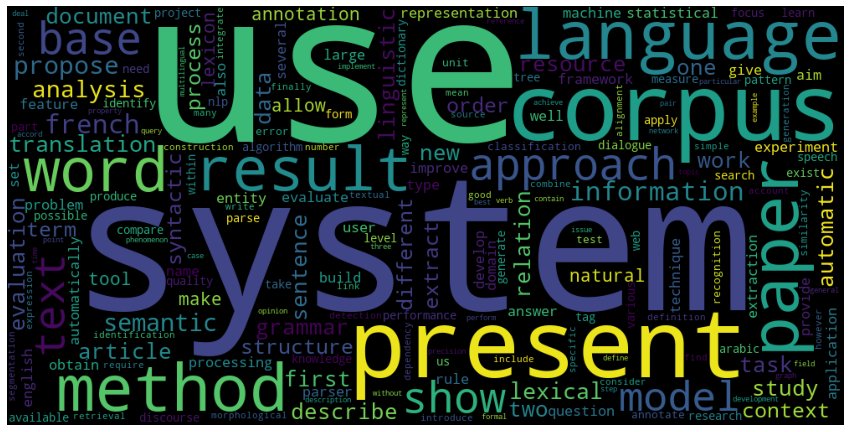

In [ ]:
my_list = (' '.join(AbstractWord)).split(" ")
word_could_dict=Counter(my_list)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

As a result, we are able to see graphically and visually that the most common word in the english abstract are use and system. 

In this case, we could've added "use" in our list of stopwords. 



> French Abstract Words



In [ ]:
AbstractWord = []
def listWordAbstract(row): 
  if len(row) != 0:
    AbstractWord.append(' '.join(row))

df['WordFR'] = df.apply(lambda row : listWordAbstract(row['processed_sent_abstractFR']), axis=1 )

fdist = FreqDist((' '.join(AbstractWord)).split(" "))
fdist.most_common(10)

[('corpus', 1064),
 ('article', 1008),
 ('systeme', 965),
 ('cet', 963),
 ('methode', 759),
 ('analyse', 736),
 ('cette', 728),
 ('automatique', 698),
 ('langue', 669),
 ('mot', 631)]

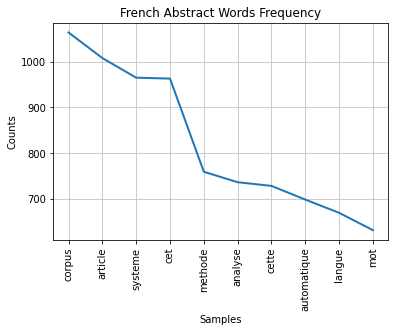

In [ ]:
fdist.plot(10,cumulative=False, title="French Abstract Words Frequency")

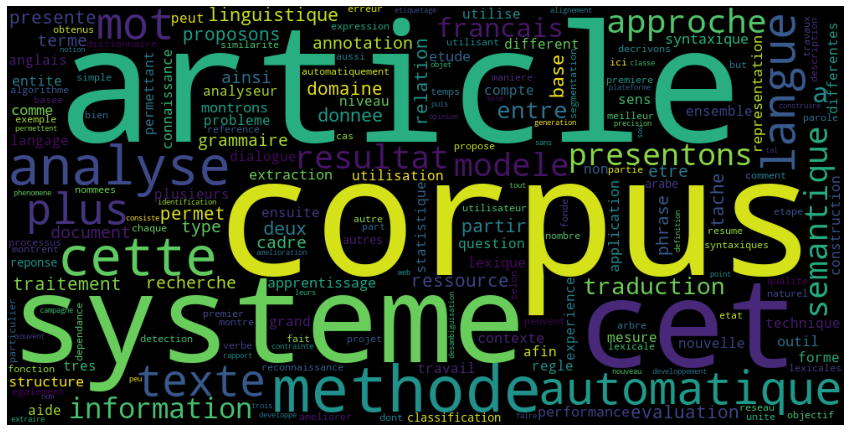

In [ ]:
my_list = (' '.join(AbstractWord)).split(" ")
word_could_dict=Counter(my_list)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We are able to see graphically and visually that the most common word in the french abstract are corpus and article. 

We noticed that in french many stopwords remain such as "cet" , "cette" , "ainsi", ... To improve our results, we could add these words to our french stopwords list as it does not seem to be complete.  



## ANALYSIS

### Keywords Evolution

Our goal in this section is to plot an evolving bar chart of the term occurrence by year, to see which words and therefore topics were the most used during the time period of the dataset. Our idea was to plot a “bar chart race” because it's the most effective way to represent tendancies. 


In [ ]:
def keywordDate(row, date):
  local = []
  for element in row:
    if len(row) != 0:
      local.append((element, date))
  return local

dfWords = df.apply(lambda row : keywordDate(row['processed_word_keywordsEN'], row['date']), axis=1 )
tmp1 = dfWords.to_frame()
tmp1.columns = ['ListTuples']

To be able to build this representation, we needed a date of use for each word so we build the tmp1 dataframe to stock this data. 
In this dataframe, the data was stocked as a list of tuples for each row, so we needed to explode it into multiple rows containing a single tuple each one.

In [ ]:
# dfTuples initialization
dfTuples = pd.DataFrame()
# transform one row containing a list of tuples to multiple rows each containing a single tuple of the list
dfTuples = pd.DataFrame(tmp1['ListTuples'].explode().tolist())
dfTuples.columns=["word_date"]
dfTuples['word'], dfTuples['date'] = dfTuples.word_date.str

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


We then tranformed the data to be usable and grouped the total word occurence by date and word.

In [ ]:
dfTuples["date"] = (dfTuples["date"]+'-01-01').astype('datetime64[ns]')
# Drop NAN values
dfTuples = dfTuples.dropna()
# Drop the word_date column
dfTuples = dfTuples.drop(columns=['word_date'])
# Output a dataframe grouping data and word column
# In column sum, it shows the frequency of the word for each year 
dfTuples['sum'] = 1
tmp2 = dfTuples.groupby(['date', 'word']).sum()
# Rest the index 
tmp2 = tmp2.reset_index()
tmp2.head()

,date,word,sum
0,1999-01-01,lattice,1
1,1999-01-01,parse,1
2,1999-01-01,processing,1
3,1999-01-01,recognition,1
4,1999-01-01,speech,1


Then, we created a pivot table from tmp2.

In [ ]:
df_final = pd.pivot_table(tmp2, values = 'sum', index=['date'], columns = 'word').reset_index()
df_final = df_final.fillna(0)
df_final = df_final.set_index('date')

In [ ]:
df_final.head()

word,10,1990,24613,3,aac,able,abstract,academic,acception,acceptions,access,acg,acl,acoustic,acquire,acquisition,across,act,actantial,actants,activation,active,activity,actr,adaptation,adaptativity,add,adjectival,adjective,adjoin,adjoints,adjunct,administrative,adptation,affect,affective,affirmation,affixation,agent,agentbuilder,...,voice,vote,vowel,vowellation,walk,wce,weak,weakly,web,webbased,weight,weka,whsentence,wide,wikipedia,wikipédia,wiktionary,window,windowdiff,wizard,word,word2vec,wordbased,wordlevel,wordnet,world,write,writing,wsd,xip,xml,xpath,yesno,zero,zeroshot,zone,étiquetage,évaluation,λcalculus,λdrt
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


Here, we have a dataframe containing the term occurence by word and by year, but if we want our barchart race to be relevant, we will need the cumulative sum of the term occurence to be able to see the evolution of the use of a term.

In [ ]:
df_final2 = df_final.cumsum()

In [ ]:
df_final2.tail()

word,10,1990,24613,3,aac,able,abstract,academic,acception,acceptions,access,acg,acl,acoustic,acquire,acquisition,across,act,actantial,actants,activation,active,activity,actr,adaptation,adaptativity,add,adjectival,adjective,adjoin,adjoints,adjunct,administrative,adptation,affect,affective,affirmation,affixation,agent,agentbuilder,...,voice,vote,vowel,vowellation,walk,wce,weak,weakly,web,webbased,weight,weka,whsentence,wide,wikipedia,wikipédia,wiktionary,window,windowdiff,wizard,word,word2vec,wordbased,wordlevel,wordnet,world,write,writing,wsd,xip,xml,xpath,yesno,zero,zeroshot,zone,étiquetage,évaluation,λcalculus,λdrt
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1.0,1.0,1.0,0.0,3.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,24.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,10.0,1.0,1.0,2.0,6.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,7.0,1.0,...,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,28.0,3.0,12.0,1.0,1.0,4.0,15.0,1.0,1.0,1.0,2.0,1.0,77.0,1.0,1.0,1.0,10.0,6.0,6.0,2.0,3.0,1.0,10.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2016-01-01,1.0,1.0,1.0,0.0,3.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,24.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,10.0,1.0,1.0,2.0,6.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,7.0,1.0,...,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,28.0,3.0,12.0,1.0,1.0,4.0,15.0,1.0,1.0,1.0,2.0,1.0,77.0,1.0,1.0,1.0,10.0,6.0,6.0,2.0,3.0,1.0,10.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2017-01-01,1.0,1.0,1.0,0.0,3.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,24.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,10.0,1.0,1.0,2.0,6.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0,...,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,28.0,3.0,12.0,1.0,1.0,4.0,15.0,1.0,1.0,1.0,2.0,1.0,77.0,1.0,1.0,1.0,10.0,6.0,6.0,2.0,3.0,1.0,10.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
2018-01-01,1.0,1.0,1.0,1.0,3.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,24.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,10.0,1.0,1.0,2.0,6.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0,...,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,28.0,3.0,12.0,1.0,1.0,4.0,15.0,1.0,1.0,1.0,2.0,1.0,77.0,1.0,1.0,1.0,10.0,6.0,6.0,2.0,3.0,1.0,10.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
2019-01-01,1.0,1.0,1.0,1.0,3.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,24.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,10.0,1.0,1.0,2.0,6.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0,...,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,28.0,3.0,12.0,1.0,1.0,4.0,15.0,1.0,1.0,1.0,2.0,1.0,78.0,1.0,1.0,1.0,10.0,6.0,6.0,2.0,3.0,1.0,10.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0


We finally obtain a dataframe displaying the cumulative sum of keywords through the years with the good shape, and containing all of our data. We can now use this dataframe with the bar_char_race function. This will generate an .mp4 file. 

This file can be found on the file section on the left side of colab once executed.

In [ ]:
bcr.bar_chart_race(
    df=df_final2,
    filename='nlp3.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_fmt='%B %d, %Y',
    period_summary_func=lambda v, r: {'x': .99, 'y': .18,
                                      's': f'Keywords: {v.nlargest(6).sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Courier New'},
    period_length=500,
    figsize=(5, 3),
    dpi=144,
    cmap='dark12',
    title='Evolution of the keywords over time',
    title_size='',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)  

To make it easier for you, we uploaded the video on youtube. It can be found here : [Keywords Evolution - Bar Chart Race](https://youtu.be/0vNe74yL9wg).

We wanted to represent in a simple and understandable way the evolution of the keywords in the articles for the period 1999-2019.


In [ ]:
Image(url= "https://i.gyazo.com/8e6ee12f13b000b435432838609394a5.png", width=700, height=350)

On this first figure extracted from our youtube video, we can observe that during the first years all the frequent words revolved around the text processing topic without any particular fields, it can be due to the fact that there were only articles back in 2001.

In [ ]:
Image(url="https://i.gyazo.com/ad4af232e23fddd32c81aaf59d81b483.png", width=700, height=350)

Ten years later, we can now have a good view of what the topics are. 
We can see that new words have appeared in the NLP field such as semantic, automatic and lexical. 

In [ ]:
Image(url= "https://i.gyazo.com/9df8c2d79c731adc2c31b0095182819c.png", width=700, height=350)

Finally, in 2018, other words have appeared such as machine and extraction, while language and corpus took the lead, after keeping a strong position through the years.

We can attribute theses changes to the democratization of the machine learning in the NLP field.

This plot is really interesting because we can follow tendancies and the evolution of the field.

### TF-IDF

TFIDF resolves this issue by multiplying the term frequency of a word by the inverse document frequency. The TF stands for "Term Frequency" while IDF stands for "Inverse Document Frequency".

We thought that using TF-IDF needed to be done in order to score the relative importance of words. 

Important note: The TFIDF value for a word in a particular document is higher if the frequency of occurrence of that word is higher in that specific document but lower in all the other documents.

A first method for scoring the relative importance of words is using the bag of words approach. This common approch is done by placing all of the words that in the text in a bucket and then we would create a dictionary of words and their occurence for each document in the corpus. However, a problem with the bag of words approach is that it does not account for noise. In other words, certain words are used to formulate senteces but do not add any sematic meaning to the text. For this reason, we decided to use another strategy: TF-IDF. 

TF = Term Frequency : The number of timew a word appeard in a document divided by the number of words in the document. 

IDF = Inverse Data Frequency (IDF) : determines the weight of rare words across all documents in the corpus. 

Rather than manually implementing TF-IDF ourselves we used the class provided by sklearn. The values would've differed slightly if we had done it manually because sklearn uses a smoothed version idf and various other little optimizations. 


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer



> English Abstract TF-IDF



Place all the sentences in a list

In [ ]:
sentences = []

def addSentence(row):
  for sentence in row:
    if len(sentence)>0:
      sentences.append(sentence)

dfSentences = df.apply(lambda row : addSentence(row['processed_sent_abstractEN']), axis=1 )

Apply the class provided by sklearn

In [ ]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(sentences)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
dfTFIDF = pd.DataFrame(denselist, columns=feature_names)

The rows represent the 5855 different sentences and the columns represent all the unique words

In [ ]:
dfTFIDF.head()

,000,04,05,065,07,09,10,100,1000,103000,105,106,109447,10k,11,1130,114,12,120,12510,1299,13,1362,1398,14,1400,140000,14318,1441,15,15000,150word,16,168,17,18,18million,18th,1955,1960,...,writer,writing,wrong,wrongly,wrt,wsd,wsi,ww,www,xbar,xerox,xiamen,xip,xm,xmg,xml,xmu,xpath,yadtk,yahoo,year,yesno,yet,yield,young,yvon,zamparelli,zero,zeroshot,zhang,zhao,zhitomirskygeffet,zipf,zipfian,zodiac,zombilingo,zone,évaluation,βcalculus,δfree
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To explain our above matrix, we will take the first sentence in the document. The sentence is show below: 

In [ ]:
first_doc_sentence = sentences[0]
first_doc_sentence

'aim paper compare behaviour polish romance pronominal clitics tense auxiliary construction account polish fact'

As the first sentence's score is the first row in our dataset we will show the tfidf score's found in descending order: 

In [ ]:
first_doc_vector = dfTFIDF.iloc[0]
first_doc_vector.sort_values(ascending=False)

polish         0.550756
pronominal     0.297023
romance        0.297023
clitics        0.297023
tense          0.279715
                 ...   
phrasal        0.000000
phrase         0.000000
phrasebased    0.000000
phrasebooks    0.000000
000            0.000000
Name: 0, Length: 7192, dtype: float64

Notice tha only certain words have scores. This is because our first document is "aim paper compare behaviour polish romance pronominal clitics tense auxiliary construction account polish fact" all the words in this document have a tf-idf score and everything else show up as zeros. 

The more common the word across documents, the lower its score and the more unique a word is to our first document the higher the score. As we can see in this first document, the word "polish" has the highest score.

In [ ]:
sum = dfTFIDF.sum(axis = 0, skipna = True) 
sum = sum.reset_index()
sum.columns = ['word', 'sum'] 
sum = sum.sort_values(by=['sum'], ascending=False)
top10 = sum.head(10)

Top ten words with the highest tfidf total sum

<BarContainer object of 10 artists>

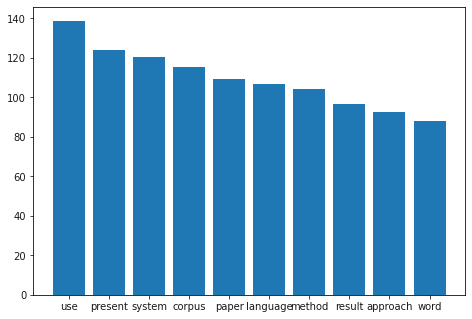

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(top10["word"],top10["sum"])


We can see that the word with the highest total tfidf is the same word as the top1 most used word in english abstract (after preprocessing).



> French Abstract TFIDF

The same approach as the English asbract method above is being used



<BarContainer object of 10 artists>

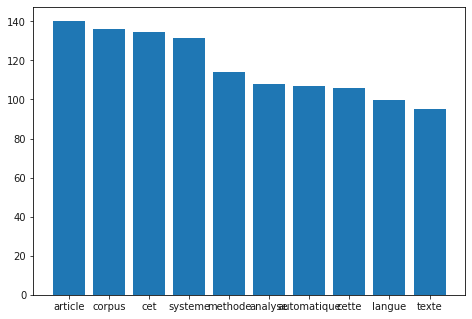

In [ ]:
sentences = []

def addSentence(row):
  for sentence in row:
    if len(sentence)>0:
      sentences.append(sentence)

dfSentences = df.apply(lambda row : addSentence(row['processed_sent_abstractFR']), axis=1 )

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(sentences)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
dfTFIDF = pd.DataFrame(denselist, columns=feature_names)

sum = dfTFIDF.sum(axis = 0, skipna = True) 
sum = sum.reset_index()
sum.columns = ['word', 'sum'] 
sum = sum.sort_values(by=['sum'], ascending=False)
top10 = sum.head(10)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(top10["word"],top10["sum"])


We can see that for the french abstract, the word "article" is the word with the highest total tfidf but this time, it is not the same word as the top1 most used word in french abstract (after preprocessing).

### Topic Modeling

Topic modeling is an unsupervised machine learning technique used for scanning a set of documents, detecting word and phrase patterns, and automatically grouping words into clusters. There are multiple methods of going about doing this, but one of the most common is Latent Dirichlet Allocation (LDA). 

In our project, we decided to use topic modeling as we had a collection of words that we wanted to group together in such a way that each group represented a topic. 


First, we made sure to remove all the english abstracts rows that were empty and kept only the column that will be processed by LDA.

In [ ]:
df_lda = df[~df.processed_sent_abstractEN.str.len().eq(0)]
df_lda = df_lda[["processed_sent_abstractEN"]]
df_lda

,processed_sent_abstractEN
17,[aim paper compare behaviour polish romance pr...
20,[current nl parser expect run throughput rate ...
25,[subject tree adjoin grammar parse inspire man...
26,[achievement accomplishment argue paper differ...
27,[lot work remain do domain well integration sp...
...,...
1431,[propose paper original semisupervised method ...
1432,[aim article present general methodology autom...
1433,[article consider application natural language...
1435,[identification processing multiword expressio...


In [ ]:
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
en_stop = set(stopwords.words('english'))

def lda_cleaner(row):
  cleaned = []
  for sentence in row:
      lowercase_sent = sentence.lower()
      words = tokenizer.tokenize(lowercase_sent)
      non_stopped_words = [i for i in words if not i in en_stop]
      cleaned.append(non_stopped_words)
  return cleaned

In [ ]:
df_lda["processed_sent_abstractEN"]=df_lda.apply(lambda row : lda_cleaner(row["processed_sent_abstractEN"]),axis=1)

In [ ]:
documents = []
def test(row):
  for sentence in row :
    documents.append(sentence)

df_lda["processed_sent_abstractEN"]=df_lda.apply(lambda row : test(row["processed_sent_abstractEN"]),axis=1)

Documents represents a list of list were each list is a list of words from a different abstract. 

In [ ]:
documents[1]

['first',
 'present',
 'system',
 'polish',
 'auxiliary',
 'briefly',
 'compare',
 'romance']

**LDA**

For the implementation of LDA we used Gensim, an open source library for unsupervised topic modeling and natural language processing, using modern statistical machine learning. 

The module gensim.models.ladmodel allows both LDA model estimation from a training corpus and inference of topic modeling on new unseen documents. 

To start of, we need to create a corpus from a list of texts: 


In [ ]:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(cleandoc) for cleandoc in documents]

Then, we train the model on the corpus: 


In [ ]:
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary)

Parameters explanation: 
- corpus: Stream of document vectors or sparse matrix of shape
- num_topics: The number of requested latent topics to be extracted from the training corpus
- id2word: Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.


**Topic Modeling Visulization**

We decided to visualize our LDA using pyLDAvis as it is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

 The area of circle represents the importance of each topic over the entire corpus, the distance between the center of circles indicate the similarity between topics. For each topic, the histogram on the right side listed the top 30 most relevant terms. The blue part of the histogram is the overall term frequency and the red represents the frequency of the word in the selected topic.

 LDA helped us extracted 3 main topics. 

 For example, topic 1's most relevant terms are "present", "use", "paper" and topic 2's relevant terms are "corpus", "use", "approach"

As a result, it is extremely difficult to differentiate the three topics and giving them a general topic as all of our documents talk about the same topic : 'nlp'. 

In [ ]:
pyLDAvis.enable_notebook()
vis = gensim.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.004319 -0.074027       1        1  36.104576
0     -0.066750  0.040493       2        1  33.301442
2      0.071069  0.033533       3        1  30.593982, topic_info=        Term        Freq       Total Category  logprob  loglift
297   corpus  717.000000  717.000000  Default  30.0000  30.0000
24    french  427.000000  427.000000  Default  29.0000  29.0000
16    system  666.000000  666.000000  Default  28.0000  28.0000
40       use  918.000000  918.000000  Default  27.0000  27.0000
249  english  137.000000  137.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
107     base  116.280622  447.745180   Topic3  -5.2406  -0.1639
55   propose  108.600661  394.587142   Topic3  -5.3089  -0.1058
16    system  113.736838  666.012810   Topic3  -5.2627  -0.5831
852     data   79.563148  249.386709   Topic3  -5.6201   0.0419
466     task   78.950687  310.971928   Topic3  -5.6278  -0.1865

[266 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1300      1  0.956892  access
1300      2  0.028144  access
1300      3  0.028144  access
1         1  0.338774     aim
1         2  0.204432     aim
...     ...       ...     ...
344       2  0.215890    word
344       3  0.425492    word
106       1  0.285350    work
106       2  0.140607    work
106       3  0.574835    work

[464 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### T-SNE PLOT

t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one.


We decided to plot using t-sne to have a visualization of the words used and see the words clearly clustered in their own sub groups. 

**Implementation**

In [ ]:
model = word2vec.Word2Vec(documents, size=100, window=100, min_count=50, workers=4)

Parameters :

- workers : Use these many worker threads to train the model (=faster training with multicore machines).
- size : dimensionality of the word vectors
- window : Maximum distance between the current and predicted word within a sentence
- min_count : Ignores all words with total frequency lower than this.

Getting the numpy very of the word "language"

In [ ]:
model.wv['language']

array([ 0.11016451,  0.126341  ,  0.07705174, -0.10873581, -0.0508877 ,
        0.13335912, -0.20978843, -0.31477088,  0.12778866, -0.1847285 ,
       -0.2050638 , -0.0465628 , -0.125259  ,  0.06256304, -0.15499695,
        0.13023783, -0.25013977, -0.06985907, -0.01174724,  0.04924882,
       -0.05384867,  0.23945332,  0.17383525,  0.19057864, -0.28222716,
        0.23729384, -0.08599621, -0.0059472 ,  0.5058595 ,  0.09215225,
       -0.16053161,  0.09800536,  0.160435  ,  0.11941689,  0.12036593,
       -0.13604166, -0.02076502, -0.08907544, -0.20326926, -0.04948851,
        0.20805757,  0.29910648,  0.01966972, -0.2291347 , -0.04121204,
        0.12449124, -0.2105272 ,  0.23319134,  0.3065535 ,  0.20726444,
       -0.14534026, -0.00898458,  0.02685725, -0.13389646, -0.15370148,
        0.25502884,  0.11207549,  0.21360116,  0.18518852,  0.09657456,
        0.02742776,  0.0376803 ,  0.21631826, -0.21790119, -0.38462508,
       -0.42078346, -0.11960848, -0.1822694 , -0.11950424,  0.02

**Plot**

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

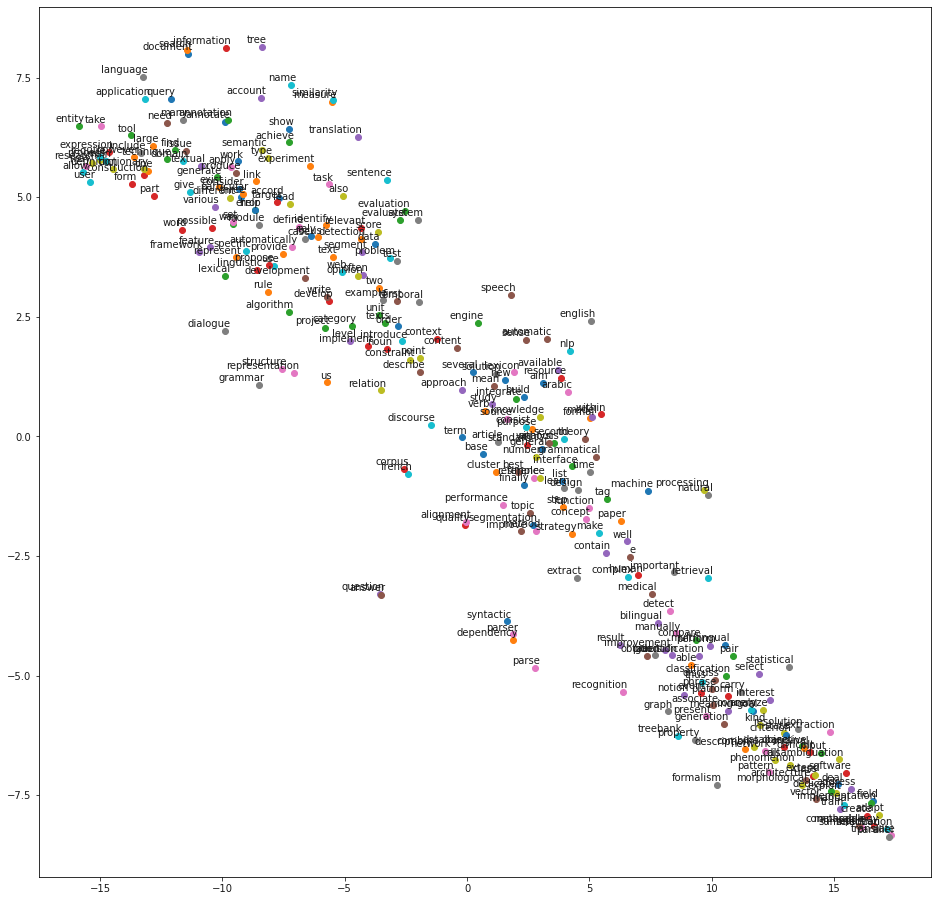

In [ ]:
tsne_plot(model)

Each color represents a different cluster. 

In conclusion, using the graph above, we can see that it is very difficult to seperate the words in different clusters.

